### ***Setup***

In [1]:
import sklearn
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import evaluate
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd

2024-01-31 18:03:10.453370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 18:03:10.622732: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 18:03:10.655047: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 18:03:11.523959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## ***Load data***

In [3]:
train = pd.read_excel('Train_with_smiles.xlsx')
valid = pd.read_excel('Valid_with_smiles.xlsx')
test = pd.read_excel('Test_with_smiles.xlsx')

data = pd.concat([train, test, valid], ignore_index=True)

cols = ['PUBCHEM_ACTIVITY_OUTCOME', 'smiles']
data = data[cols]
data = data.rename(columns={'PUBCHEM_ACTIVITY_OUTCOME': 'labels'})

label_map = {
    'Active': 1,
    'Inactive': 0,
}

data['labels'] = data['labels'].map(label_map)

In [4]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state = 42, stratify=data['labels'])
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state = 42,  stratify=train_df['labels'])

<AxesSubplot:>

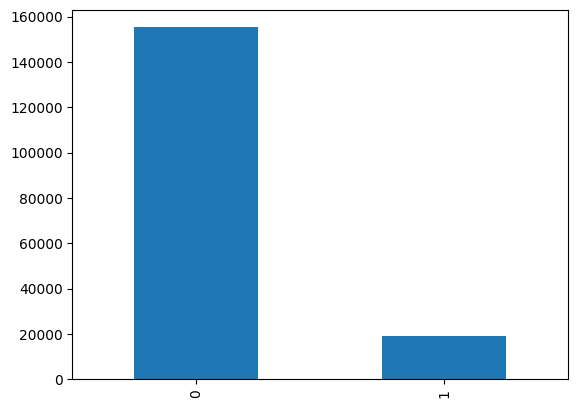

In [5]:
train_df['labels'].value_counts().plot.bar()

## ***Class balancing for training set***

In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Create a pipeline with both oversampling and undersampling steps
pipeline = Pipeline([
    ('over', RandomOverSampler(sampling_strategy=0.5)),  # Adjust sampling_strategy as needed
    ('under', RandomUnderSampler(sampling_strategy=1.0))  # Adjust sampling_strategy as needed
])

# Fit and apply the pipeline to the dataset
X_resampled, y_resampled = pipeline.fit_resample(train_df.drop('labels', axis=1), train_df['labels'])

# Combine the resampled features and labels into a new DataFrame
train_df = pd.DataFrame(X_resampled, columns=train_df.drop('labels', axis=1).columns)
train_df['labels'] = y_resampled

<AxesSubplot:>

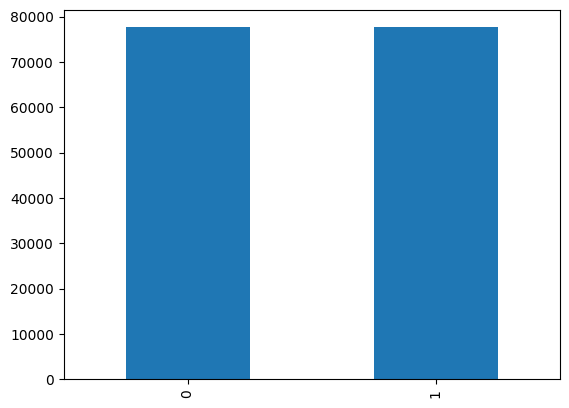

In [7]:
train_df['labels'].value_counts().plot.bar()

## ***Combine test and train sets***

In [8]:
tes_df, res_df = train_test_split(test_df, test_size=0.2, random_state = 42, stratify=test_df['labels'])

In [9]:
tes_df, tra_df = train_test_split(train_df, test_size=0.07, random_state = 42, stratify=train_df['labels'])

In [10]:
tra_df = tra_df.reset_index()
res_df = res_df.reset_index()

In [11]:
data = pd.concat([tra_df,res_df], axis=0)

In [12]:
from datasets import Dataset, DatasetDict

ds_dict = {'data' : Dataset.from_pandas(data)}

ds = DatasetDict(ds_dict)

In [13]:
from transformers import AutoModel
model = AutoModel.from_pretrained("model_tf")

Some weights of the model checkpoint at model_tf were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at model_tf and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import AutoTokenizer

checkpoint = 'seyonec/PubChem10M_SMILES_BPE_450k'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

## ***Getting last hidden states***

In [15]:
def tokenize_function(examples):

    return tokenizer(examples["smiles"],truncation=True,padding = True, return_tensors='pt')

tokenized_datasets1 = ds.map(tokenize_function, batched=True)

  0%|          | 0/22 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [16]:
after_model=model.base_model.to(device)

In [17]:
def extract_hidden_states(batch):

  inputs_dict = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    hidden = after_model(**inputs_dict).last_hidden_state

  return {'hidden_state':hidden[:,0].cpu().numpy()}

In [18]:
tokenized_datasets1.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [19]:
#torch.cuda.set_max_workspace_size(256 * 1024 * 1024) 

In [19]:
hidden = tokenized_datasets1.map(extract_hidden_states, batched=True)

  0%|          | 0/22 [00:00<?, ?ba/s]

In [20]:
import gc

del train_df
del test_df
del tra_df
del res_df
del tokenized_datasets1

gc.collect()

71

## Locally Linear Embedding

In [22]:
labels = hidden['data']['labels']

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding

scaler = StandardScaler()
hidden_state_normalized = scaler.fit_transform(hidden['data']['hidden_state'])

In [32]:
embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=40, method = 'standard')
transformed = embedding.fit_transform(hidden_state_normalized)

<AxesSubplot:xlabel='LLE_1', ylabel='LLE_2'>

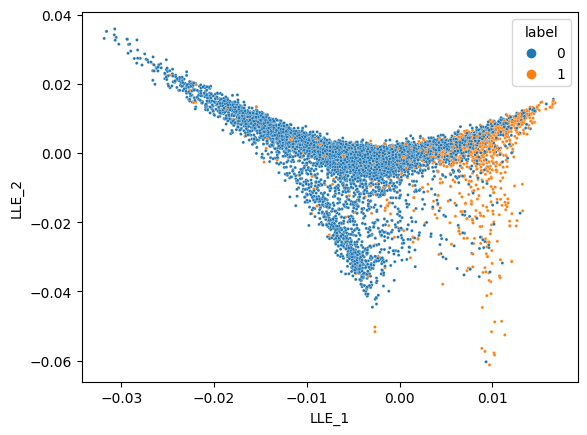

In [33]:
result_df = pd.DataFrame({'LLE_1': transformed[:,0], 'LLE_2': transformed[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='LLE_1', y='LLE_2', hue='label', data=result_df, ax=ax,s=5)